## Regression Case Study


### Business Context

Ask a home buyer to describe their dream house, and they probably won’t begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.


### Setting working directory

In [3]:

getwd()
setwd("/home/jovyan/work/Data")


[1] "/home/jovyan/work"

### Reading the dataset

In [4]:
train <- read.csv("train.csv")
test <- read.csv("test.csv")

### Separating the numeric and categorical variable

In [5]:
numeric_var <- train[which(sapply(train, is.numeric))]
sub <- which(sapply(train, is.numeric))
cat_var <- train[,-sub]

### Basic Data Exploration

The housing data set has 1460 rows and 81 features.

Hypothesis:

    Do we think about this variable when we are buying a house?

    If so, how important would this variable be? (e.g. What is the impact of having ‘Excellent’ material on the exterior instead of ‘Poor’? And of having ‘Excellent’ instead of ‘Good’?).

    Is this information already described in any other variable? (e.g. If ‘LandContour’ gives the flatness of the property, do we really need to know the ‘LandSlope’?).


In [3]:
dim(train)

[1] 1460   81

### Looking into few rows of data

In [4]:
head(train)

Id MSSubClass MSZoning LotFrontage LotArea Street Alley LotShape LandContour
1 1  60         RL       65           8450   Pave   NA    Reg      Lvl        
2 2  20         RL       80           9600   Pave   NA    Reg      Lvl        
3 3  60         RL       68          11250   Pave   NA    IR1      Lvl        
4 4  70         RL       60           9550   Pave   NA    IR1      Lvl        
5 5  60         RL       84          14260   Pave   NA    IR1      Lvl        
6 6  50         RL       85          14115   Pave   NA    IR1      Lvl        
  Utilities ⋯ PoolArea PoolQC Fence MiscFeature MiscVal MoSold YrSold SaleType
1 AllPub    ⋯ 0        NA     NA    NA            0      2     2008   WD      
2 AllPub    ⋯ 0        NA     NA    NA            0      5     2007   WD      
3 AllPub    ⋯ 0        NA     NA    NA            0      9     2008   WD      
4 AllPub    ⋯ 0        NA     NA    NA            0      2     2006   WD      
5 AllPub    ⋯ 0        NA     NA    NA            0     12     2008   WD      
6 AllPub    ⋯ 0        NA     MnPrv Shed        700     10     2009   WD      
  SaleCondition SalePrice
1 Normal        208500   
2 Normal        181500   
3 Normal        223500   
4 Abnorml       140000   
5 Normal        250000   
6 Normal        143000

In [10]:
install.packages("mice")
install.packages("caret")
install.packages("Hmisc")
install.packages("corrplot")
install.packages("dummies")
install.packages("forcats")
install.packages("randomForest")
install.packages("lattice")
install.packages("ggplot2")


also installing the dependencies ‘rpart’, ‘survival’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
also installing the dependencies ‘numDeriv’, ‘SQUAREM’, ‘KernSmooth’, ‘lava’, ‘kernlab’, ‘CVST’, ‘DEoptimR’, ‘class’, ‘prodlim’, ‘DRR’, ‘robustbase’, ‘sfsmisc’, ‘ipred’, ‘dimRed’, ‘ddalpha’, ‘gower’, ‘RcppRoll’, ‘recipes’, ‘withr’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
also installing the dependencies ‘backports’, ‘checkmate’, ‘htmlwidgets’, ‘Formula’, ‘latticeExtra’, ‘cluster’, ‘acepack’, ‘gridExtra’, ‘data.table’, ‘htmlTable’, ‘viridis’

Warning message in install.packages("Hmisc"):
“installation of package ‘viridis’ had non-zero exit status”Warning message in install.packages("Hmisc"):
“installation of package ‘Hmisc’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML inde

In [11]:
library(mice)
library(caret)
library(corrplot)
library(dummies)
library(forcats)
library(randomForest)
library(lattice)
library(ggplot2)
library(Hmisc)

Loading required package: lattice
Loading required package: ggplot2
corrplot 0.84 loaded
dummies-1.5.6 provided by Decision Patterns

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin



ERROR: Error in library(Hmisc): there is no package called ‘Hmisc’


### Summary

In [12]:
summary(numeric_var[,c(1:4)])

       Id           MSSubClass     LotFrontage        LotArea      
 Min.   :   1.0   Min.   : 20.0   Min.   : 21.00   Min.   :  1300  
 1st Qu.: 365.8   1st Qu.: 20.0   1st Qu.: 59.00   1st Qu.:  7554  
 Median : 730.5   Median : 50.0   Median : 69.00   Median :  9478  
 Mean   : 730.5   Mean   : 56.9   Mean   : 70.05   Mean   : 10517  
 3rd Qu.:1095.2   3rd Qu.: 70.0   3rd Qu.: 80.00   3rd Qu.: 11602  
 Max.   :1460.0   Max.   :190.0   Max.   :313.00   Max.   :215245  
                                  NA's   :259                      

### Looking into correlations

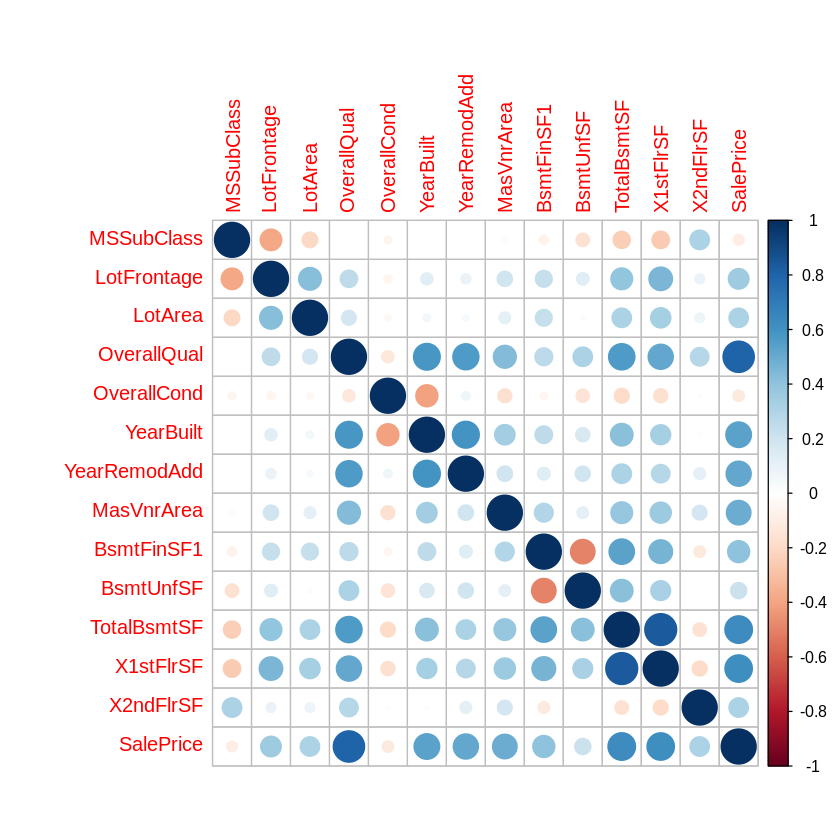

In [13]:
library(corrplot)
correlations <- cor(na.omit(numeric_var[,c(2:15,38)], with = FALSE))
row_indic <- apply(correlations, 1, function(x) sum(x > 0.3 | x < -0.3) > 1)
correlations<- correlations[row_indic ,row_indic ]
corrplot(correlations, method="circle",insig = "pch",pch.cex = 1)

There is some slight negative correlation between OverallCond and SalePrice. There is also strong negative correlation between Yearbuilt and OverallCond. It seems to be that recently built houses tend to been in worse Overall Condition.

    ‘OverallQual’, ‘GrLivArea’ and ‘TotalBsmtSF’ are strongly correlated with ‘SalePrice’.

    ‘GarageCars’ and ‘GarageArea’ are also some of the most strongly correlated variables.

### Looking into the dependent variable

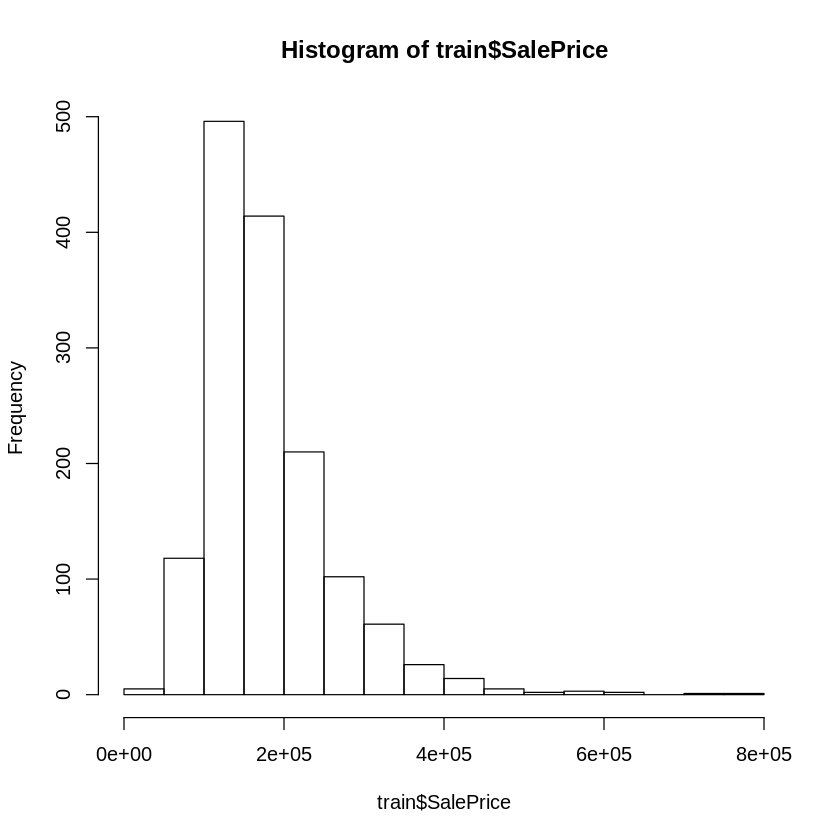

In [14]:
hist(train$SalePrice)

The histogram shows that it is positively skewed

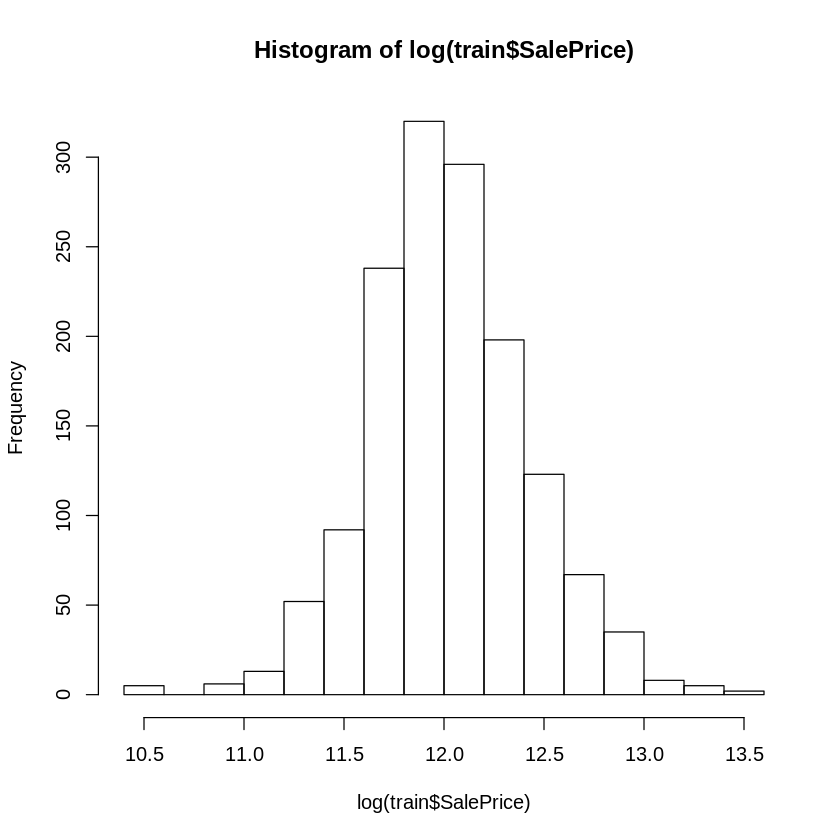

In [26]:
hist(log(train$SalePrice))

### Missing Value Treatment

    How prevalent is the missing data?

    Is missing data random or does it have a pattern?


In [15]:
a <- data.frame(round((colSums(sapply(train, is.na))/nrow(train)*100),2))
colnames(a) <- "Missing_Value_Percent"
a$variable <- rownames(a)
a[order(a$Missing_Value_Percent,rownames(a),decreasing = T),]

Missing_Value_Percent variable     
PoolQC        99.52                 PoolQC       
MiscFeature   96.30                 MiscFeature  
Alley         93.77                 Alley        
Fence         80.75                 Fence        
FireplaceQu   47.26                 FireplaceQu  
LotFrontage   17.74                 LotFrontage  
GarageYrBlt    5.55                 GarageYrBlt  
GarageType     5.55                 GarageType   
GarageQual     5.55                 GarageQual   
GarageFinish   5.55                 GarageFinish 
GarageCond     5.55                 GarageCond   
BsmtFinType2   2.60                 BsmtFinType2 
BsmtExposure   2.60                 BsmtExposure 
BsmtQual       2.53                 BsmtQual     
BsmtFinType1   2.53                 BsmtFinType1 
BsmtCond       2.53                 BsmtCond     
MasVnrType     0.55                 MasVnrType   
MasVnrArea     0.55                 MasVnrArea   
Electrical     0.07                 Electrical   
YrSold         0.00                 YrSold       
YearRemodAdd   0.00                 YearRemodAdd 
YearBuilt      0.00                 YearBuilt    
X3SsnPorch     0.00                 X3SsnPorch   
X2ndFlrSF      0.00                 X2ndFlrSF    
X1stFlrSF      0.00                 X1stFlrSF    
WoodDeckSF     0.00                 WoodDeckSF   
Utilities      0.00                 Utilities    
TotRmsAbvGrd   0.00                 TotRmsAbvGrd 
TotalBsmtSF    0.00                 TotalBsmtSF  
Street         0.00                 Street       
⋮             ⋮                     ⋮            
LandContour   0                     LandContour  
KitchenQual   0                     KitchenQual  
KitchenAbvGr  0                     KitchenAbvGr 
Id            0                     Id           
HouseStyle    0                     HouseStyle   
HeatingQC     0                     HeatingQC    
Heating       0                     Heating      
HalfBath      0                     HalfBath     
GrLivArea     0                     GrLivArea    
GarageCars    0                     GarageCars   
GarageArea    0                     GarageArea   
Functional    0                     Functional   
FullBath      0                     FullBath     
Foundation    0                     Foundation   
Fireplaces    0                     Fireplaces   
ExterQual     0                     ExterQual    
Exterior2nd   0                     Exterior2nd  
Exterior1st   0                     Exterior1st  
ExterCond     0                     ExterCond    
EnclosedPorch 0                     EnclosedPorch
Condition2    0                     Condition2   
Condition1    0                     Condition1   
CentralAir    0                     CentralAir   
BsmtUnfSF     0                     BsmtUnfSF    
BsmtHalfBath  0                     BsmtHalfBath 
BsmtFullBath  0                     BsmtFullBath 
BsmtFinSF2    0                     BsmtFinSF2   
BsmtFinSF1    0                     BsmtFinSF1   
BldgType      0                     BldgType     
BedroomAbvGr  0                     BedroomAbvGr

Certain thing to note before you start imputing the values.

The categorical variables with the largest number of missing values are: Alley, FirePlaceQu, PoolQC, Fence, and MiscFeature.

1.Alley: Type of alley access to property (NA No alley access)

2.BsmtQual: Evaluates the height of the basement (NA No Basement)

3.BsmtCond: Evaluates the general condition of the basement (NA No Basement)

4.BsmtExposure , BsmtFinType1, BsmtFinType2 ( NA No Basement)

5.FireplaceQu: Fireplace quality (NA No Fireplace)

6.GarageType, GarageFinish, GarageQual, GarageCond: (NA No Garage)

7.Fence: Fence quality (NA No Fence)

8.PoolQC: Pool quality (NA No Pool)

9.MiscFeature : NA - None

The missing values indicate that majority of the houses do not have alley access, no pool, no fence and no elevator, 2nd garage, shed or tennis court that is covered by the MiscFeature.

### IMputing missing values

In [16]:
col <- c("Alley","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1",
         "BsmtFinType2","FireplaceQu","GarageType","GarageFinish",
         "GarageQual", "GarageCond","PoolQC" ,"Fence","MiscFeature" )

### Getting the dataframe only for those columns where NA represents some level

In [17]:
new <- train[,which(names(train) %in% col)]
describe(new[,c(1,2)])

ERROR: Error in eval(expr, envir, enclos): could not find function "describe"


### Separating the columns where NA represents some level

In [18]:
train1 <- train[,-which(names(train) %in% col)]

### Changing the level info from the dataset

In [19]:
for(i in colnames(new)){
  new[,i] <- fct_explicit_na(new[,i], na_level=paste("No",i))
}

### Removing certain variables depending on proportion

In [20]:
remove <- c("MiscFeature","Fence","PoolQC","Alley")
new <- new[,-which(names(new) %in% remove)]

### Missing value in numeric variaable

In [21]:
sum(is.na(numeric_var))

[1] 348

### Imputing Missing value depending on Prredictive mean matching method

In [22]:
tempData <- mice(numeric_var,m=1,method ='cart',seed=500,printFlag = F)
completedData <- complete(tempData,1)

First let’s look at how well the LotFrontage data were imputed, since it is the only numeric variable that had missing data. LotFrontage is probably highly correlated with the LotArea variable. 
Let’s make a scatter plot of the two:

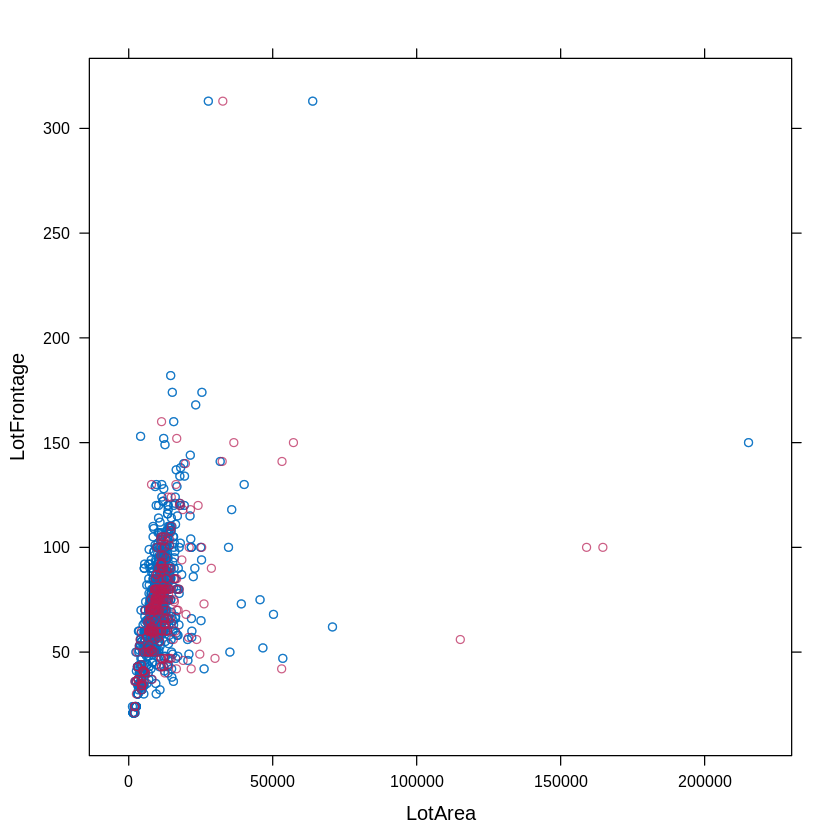

In [23]:
xyplot(tempData, LotFrontage ~ LotArea)

The imputed data (in red) appear to have a similar relationship to LotArea as the actual data (in blue).

Let’s look at the distribution of the imputed data.

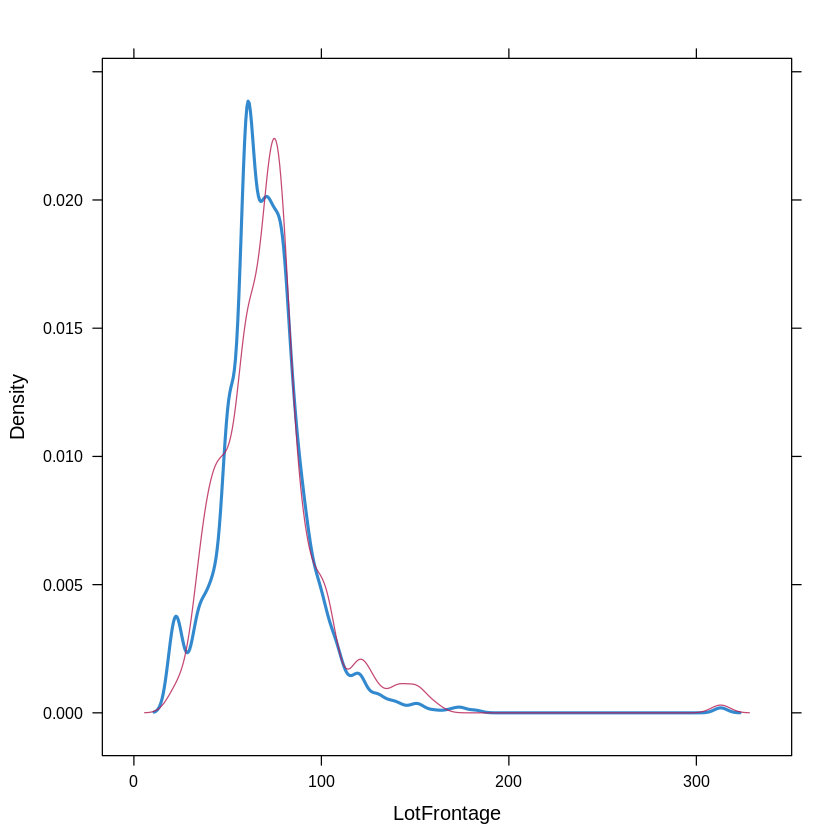

In [24]:
densityplot(tempData, ~LotFrontage)

Let’s compare to how this would look if instead we had used a simple mean to replace NAs.

In [25]:
train_raw_mean <- mice(numeric_var, 
                           m=1, 
                           defaultMethod=c('mean', 'cart', 'cart', 'cart'),
                           printFlag=FALSE)

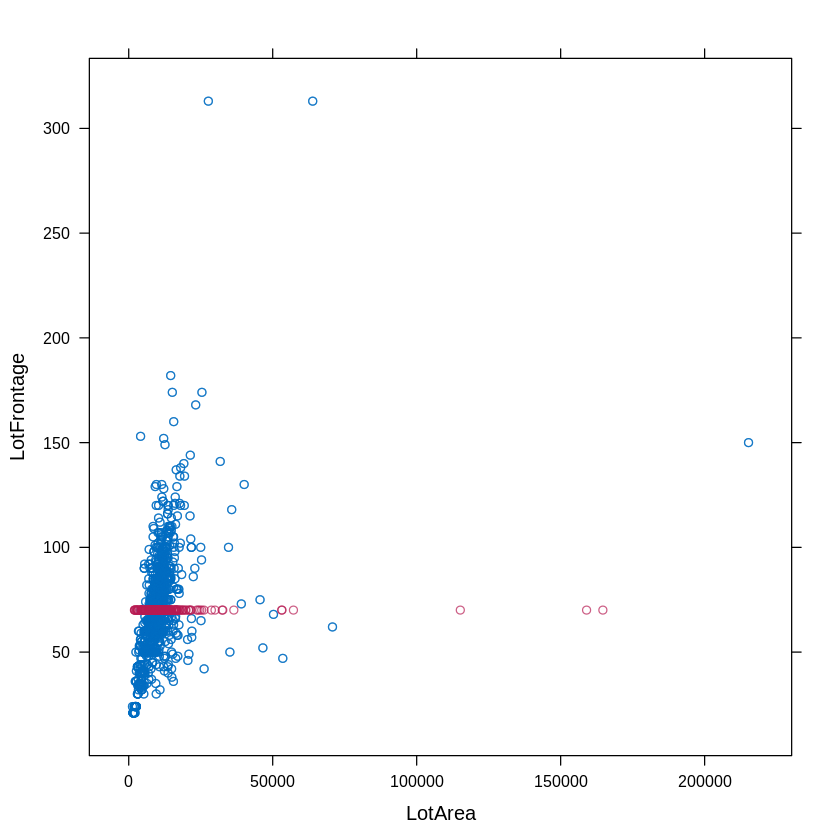

In [26]:
xyplot(train_raw_mean, LotFrontage ~ LotArea)

Try different methods before you impute the data.Dont use the same method.
### After Imputation

In [27]:
sum(is.na(tempData))

[1] 0

### Taking the columns where NA represents missing value

In [28]:
cat_var1 <- cat_var[,-which(names(cat_var) %in% col)]


### Imputation of categorical variable

In [29]:
tempData1 <- mice(cat_var1,m=1,method='cart',seed=500,printFlag = F)
completedData1 <- complete(tempData1,1)

### Number of missing values

In [30]:
sum(is.na(cat_var))

[1] 6617

In [31]:
sum(is.na(cat_var1))

[1] 9

In [32]:
sum(is.na(tempData1))

[1] 0

### Final dataframe for modelling

In [33]:
final <- cbind.data.frame(completedData,completedData1,new)

### Splitting the dataset into train and test

In [34]:
index <- createDataPartition(y=final$SalePrice, p=0.70, list=FALSE)  
train_part <- final[index,]
test_part <- final[-index,]

### Comparing overall quality with respect to Sale price

In [35]:
qual_sale <- data.frame(tapply(train$SalePrice,train$OverallQual,FUN = median))

We can see that Sales Price Increases as Quality Increases

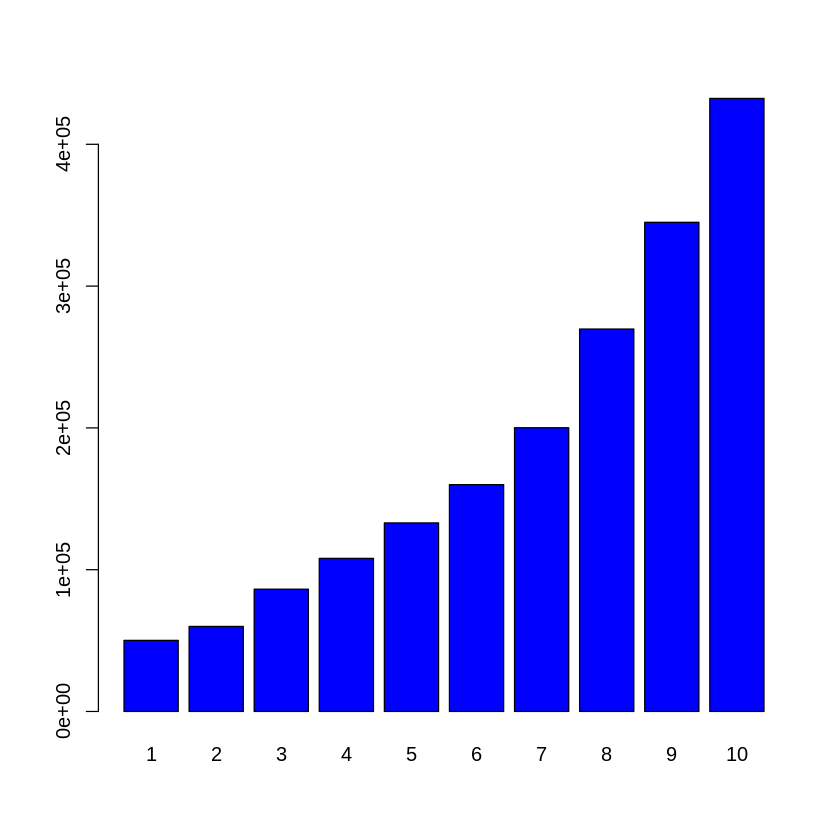

In [36]:
barplot(qual_sale$tapply.train.SalePrice..train.OverallQual..FUN...median.,col = "blue")

### Taking variables from the variable importance

In [37]:
var <- c("OverallQual","GarageArea",  "OverallCond","BsmtQual",
        "X1stFlrSF","YearBuilt","X2ndFlrSF",
        "BsmtFinSF1",  "LotArea","SalePrice")

### Selecting only those variables that is important

In [59]:
final_imp <- final[,which(names(final) %in% var)]

### Modelling

In [40]:
lm.mod <- lm(log(final_imp$SalePrice)~ .,final_imp)
summary(lm.mod)


Call:
lm(formula = log(final_imp$SalePrice) ~ ., data = final_imp)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.47976 -0.06529  0.00972  0.07959  0.48717 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          4.141e+00  4.747e-01   8.724  < 2e-16 ***
LotArea              2.931e-06  4.454e-07   6.581 6.51e-11 ***
OverallQual          8.956e-02  5.171e-03  17.317  < 2e-16 ***
OverallCond          5.798e-02  4.165e-03  13.920  < 2e-16 ***
YearBuilt            3.291e-03  2.382e-04  13.816  < 2e-16 ***
BsmtFinSF1           4.725e-05  1.063e-05   4.445 9.45e-06 ***
X1stFlrSF            3.276e-04  1.583e-05  20.689  < 2e-16 ***
X2ndFlrSF            2.369e-04  1.156e-05  20.490  < 2e-16 ***
GarageArea           2.201e-04  2.596e-05   8.479  < 2e-16 ***
BsmtQualFa          -1.392e-01  3.671e-02  -3.792 0.000155 ***
BsmtQualGd          -7.621e-02  1.770e-02  -4.306 1.77e-05 ***
BsmtQualTA          -1.146e-01  2.210e-02  -5.187 2.45e-0

### Assumptions of Linear Regression

1.Normality -For fixed values of the independent variables, the dependent variable is normally distributed.

2.Independence -The Yi values are independent of each other.

3.Linearity -The dependent variable is linearly related to the independent variables.

4.Homoscedasticity -The variance of the dependent variable doesn’t vary with the levels of the independent variables. We could call this constant variance, but saying homoscedasticity makes me feel smarter.

### Multicollinearity Check

In [41]:
install.packages('car')
library(car)
vif(lm.mod)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


GVIF     Df GVIF^(1/(2*Df))
LotArea     1.153704 1  1.074106       
OverallQual 2.985623 1  1.727895       
OverallCond 1.253829 1  1.119745       
YearBuilt   3.020428 1  1.737938       
BsmtFinSF1  1.371651 1  1.171175       
X1stFlrSF   2.187070 1  1.478875       
X2ndFlrSF   1.487238 1  1.219524       
GarageArea  1.798664 1  1.341143       
BsmtQual    3.545790 4  1.171424

### Plotting

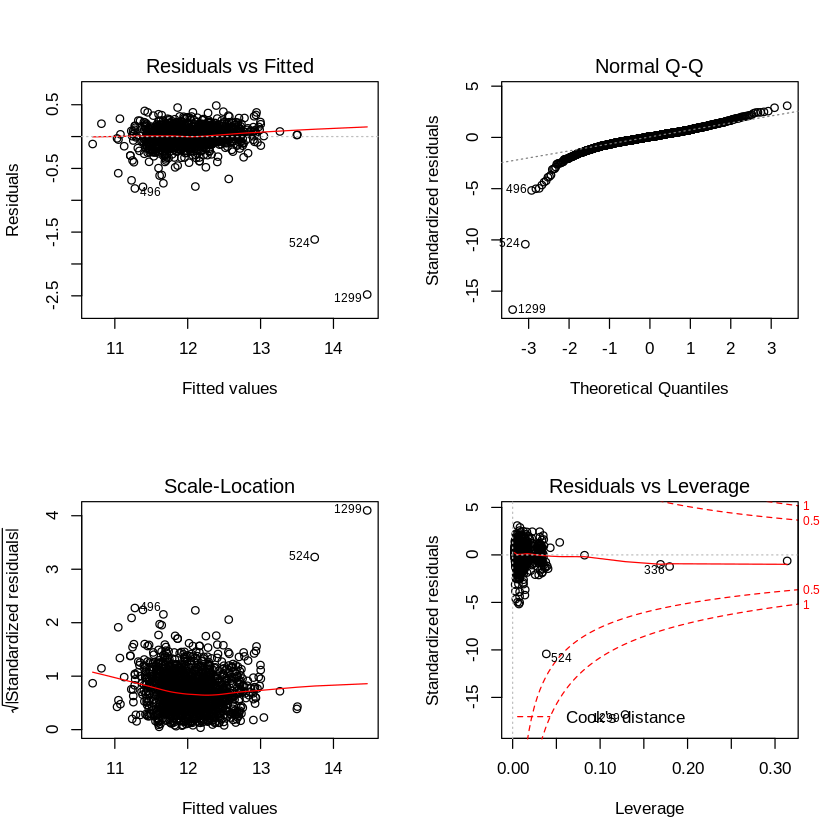

In [56]:
par(mfrow=c(2,2))
plot(lm.mod)

### QQ Plot

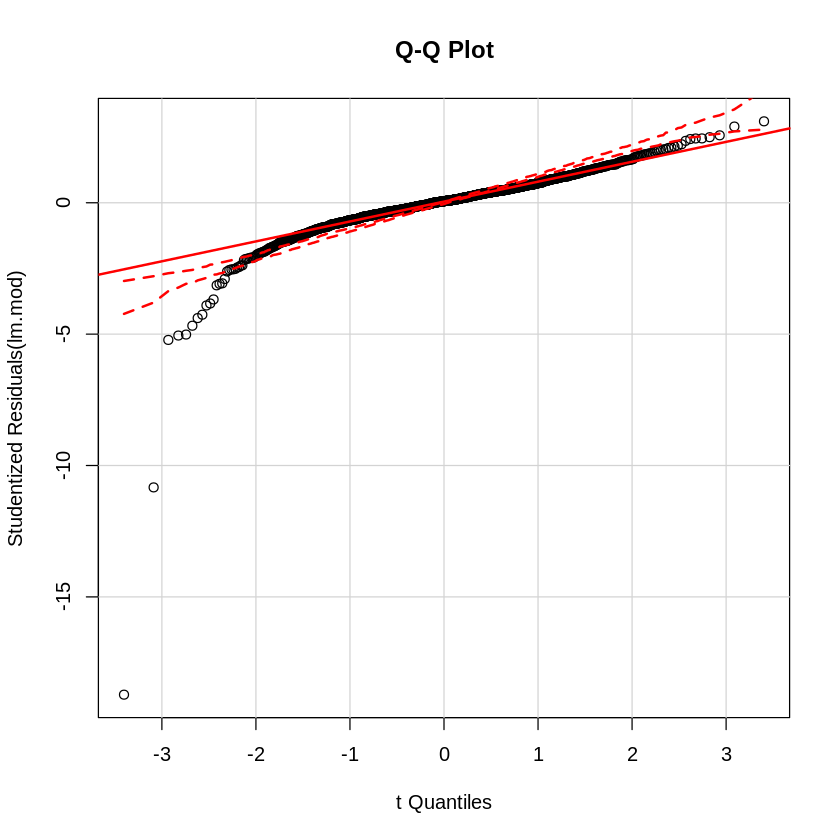

In [57]:
par(mfrow=c(1,1))
qqPlot(lm.mod, labels=row.names(final_imp), id.method="identify",
       simulate=TRUE, main="Q-Q Plot")

In [58]:
durbinWatsonTest(lm.mod)

 lag Autocorrelation D-W Statistic p-value
   1      0.01804421      1.963762   0.434
 Alternative hypothesis: rho != 0

Null hypothesis is there is no correlation among the residuals

The nonsignificant p-value (p=0.434) suggests there is correlation among residuals

### Homoscedasticity

The ncvTest() function produces a score test of the hypothesis of constant error variance against the alternative that the error variance changes with the level of the fitted values

In [59]:
ncvTest(lm.mod)

Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 1145.683    Df = 1     p = 3.891364e-251 

### OutlierTest

In [60]:
outlierTest(lm.mod)

       rstudent unadjusted p-value Bonferonni p
1299 -18.721049         3.3895e-70   4.9486e-67
524  -10.832815         2.3961e-26   3.4983e-23
496   -5.220460         2.0449e-07   2.9855e-04
31    -5.053701         4.8862e-07   7.1339e-04
633   -5.016155         5.9241e-07   8.6492e-04
813   -4.680087         3.1360e-06   4.5786e-03
969   -4.389047         1.2211e-05   1.7829e-02
1325  -4.260145         2.1749e-05   3.1754e-02

### Leverage Points

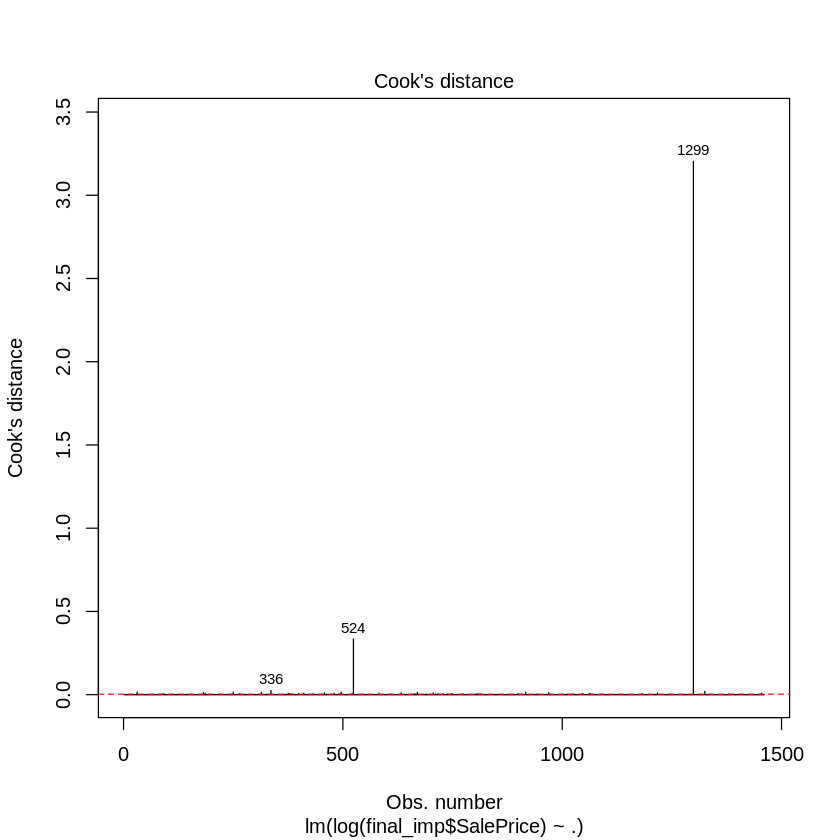

In [42]:
cutoff <- 4/(nrow(final_imp)-length(lm.mod$coefficients)-2)
plot(lm.mod, which=4, cook.levels=cutoff)
abline(h=cutoff, lty=2, col="red")

### Outliers to be removed

In [47]:
final_imp <- final_imp[-c(524,1299,496),]

### Predict test dataset

In [62]:
pred <- predict(lm.mod,test_part[,-c(38)])

### Comparison Metric

In [49]:
RMSE(pred,log(test_part$SalePrice))

[1] 0.1392227

### Adding my prediction to the test data

In [65]:
test_part$Pred_Sale_Price <- exp(pred)

## PASTE YOUR FINAL RESULTS IN THE SECTION BELOW

In [ ]:
OUTPUT
Highest LotFrontage Value=
Percentage of missing values in LotFrontage=
Minimum residal value for the prediction model=
Highest value of Dimension Adjusted VIF=
Comparison Metric Used=
Comparison Metric Value=